In [107]:
#load_ext autoreload
import matplotlib.pyplot as plt
from RNN_lib import CustomRNN, K_bit_flip_flop, coherence_task, train
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv
from scipy.stats import pearsonr
from rnn_class import RNN
from utils_kbit import get_data_from_kbit_task
from utils_admm import solve_corrn_admm
from utils_admm import solve_corrn_admm_gpu
from utils_kbit import generate_test_data
from matplotlib import cm
#%% Load modal and task
task_size = 100;
alph = 0.9
n_rec = 1000
num_trials = 200

# load the k-bit flip flop model
kbit_rnn = torch.load("kbit_data/model_kbit_0_%s_%s.pt" %(alph,n_rec),map_location=torch.device('cpu'))
kbit_rnn.eval()

# load the k-bit flip flop task
kbit_task = torch.load("kbit_task.pt")
kbit_task.T = task_size;
# the get_params function returns the weights of the network, and the alpha parameter
# in a dictionary
kbit_rnn_params = kbit_rnn.get_params()


# for each parameter, print the parameter name and the shape of the parameter
# except for alpha, which is a scalar
for param_name, param in kbit_rnn_params.items():
    if param_name != "alpha":
        print(param_name, param.shape)
    else:
        print(param_name, param)
        
    if param_name == "W_rec":
        w_rec_gnd = np.array(param);
        gnd = w_rec_gnd.copy().T.flatten()
        
    if param_name == "W_out":
        w_out = np.array(param);

#%%
opts = {'alpha' : alph,
                'n_in' : 3,
                'sigma_input' : 1e-2,
                'sigma_conversion' : 1e-3,
                'verbose' : 0,
                'n_rec' : n_rec}
data,rnn_gnd,trial_vars = get_data_from_kbit_task(num_trials,\
                                alph,n_rec,0,opts,task_size)

r_in = data['r_in']
r_out = data['r_out']
u = data['u']

w_rec = rnn_gnd['w_rec'].T
w_in = rnn_gnd['w_in'].T
w_out = rnn_gnd['w_out']

#%%


w = solve_corrn_admm_gpu(r_in,r_out,u_in = u, alph = alph, 
                                        l2 = 1e-6, threshold = 1, rho = 100,
                                        verbose = 2, 
                                        num_iters = 100,gnd = gnd,solver_type = 'weighted')
w_rec_cornn = w[:n_rec,:].T
w_in_cornn = w[n_rec:,:].T


#%%


opts = {};
opts['n_rec'] = n_rec
opts['n_in'] = 3
opts['alpha'] = alph
opts['verbose'] = False;
opts['sigma_input'] = 1e-2
opts['sigma_conversion'] =1e-3

m1 = RNN(opts)
m1.rnn['w_rec'] = w_rec
m1.rnn['w_in'] = w_in

m2 = RNN(opts)
m2.rnn['w_rec'] = w_rec_cornn
m2.rnn['w_in'] = w_in_cornn

T_test = 200

inputs, outputs = generate_test_data(T_test)

inputs_all = np.r_[inputs, np.zeros([100,3])]

r = m1.get_time_evolution(T = inputs.shape[0] + 100, u =inputs_all)
r_cornn = m2.get_time_evolution(T = inputs.shape[0]+ 100, u =inputs_all,r_in = r[0,:])

z_out = r[1:,:] @ w_out

z_out_cornn = r_cornn[1:,:] @ w_out

W_in (3, 1000)
W_rec (1000, 1000)
W_out (1000, 3)
alpha 0.9
01:24:20: Running CoRNN solver.
	 01:24:23: Performing initial inverse operations
	 01:24:23: Fixed point. f1 0.9652. cor: 0.982 and slope 0.949. Starting iterations
	 	 01:24:24: Iteration 10 finished. F1: 0.9977. Correlation 0.996. Slope 1.000. Not used 0.02. Convergence 0.062763.
	 	 01:24:25: Iteration 20 finished. F1: 0.9977. Correlation 0.996. Slope 1.000. Not used 0.02. Convergence 0.034036.
	 	 01:24:26: Iteration 30 finished. F1: 0.9977. Correlation 0.996. Slope 1.000. Not used 0.02. Convergence 0.018336.
	 	 01:24:27: Iteration 40 finished. F1: 0.9977. Correlation 0.996. Slope 1.000. Not used 0.02. Convergence 0.010198.
	 	 01:24:28: Iteration 50 finished. F1: 0.9977. Correlation 0.996. Slope 1.000. Not used 0.02. Convergence 0.005541.
	 	 01:24:29: Iteration 60 finished. F1: 0.9977. Correlation 0.995. Slope 1.000. Not used 0.02. Convergence 0.003090.
	 	 01:24:30: Iteration 70 finished. F1: 0.9977. Correlation 0.995

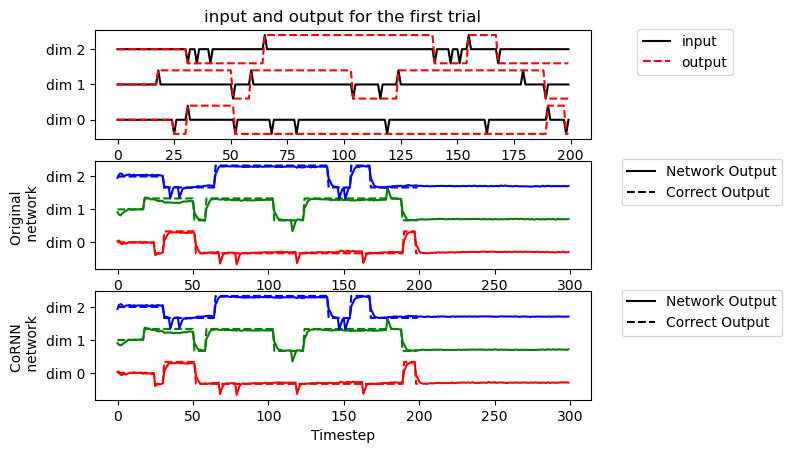

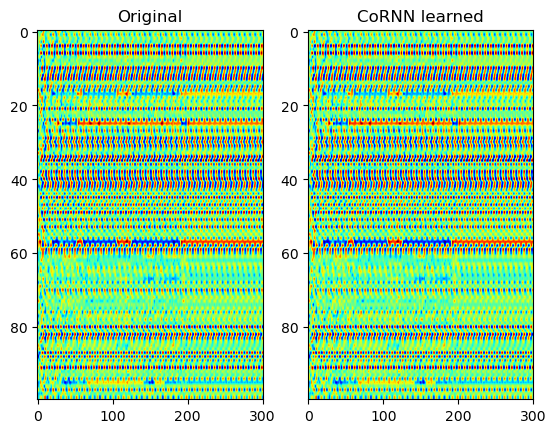

(-0.5, 0.5)

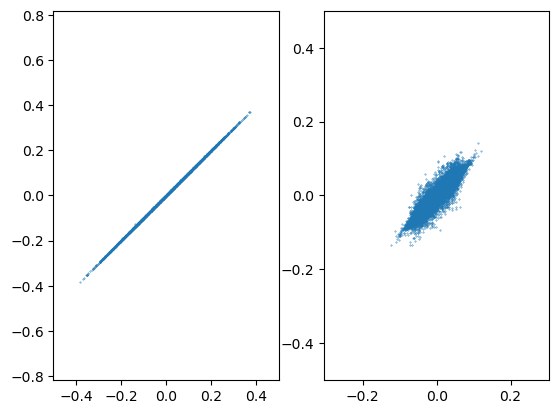

In [108]:
#% Plot the task structure
plt.subplot(311)
kbit_task.visualize_trial(inputs, outputs)
plt.subplot(312)
kbit_task.visualize_rnn_output(z_out, outputs)
plt.ylabel('Original \n network')
plt.subplot(313)
kbit_task.visualize_rnn_output(z_out_cornn, outputs)
plt.ylabel('CoRNN \n network')
plt.show()

#% Plot the neural activities 
plt.subplot(121)
plt.imshow(r[:,:100].T,aspect = 'auto',cmap = 'jet',interpolation = None)
plt.title('Original')
plt.subplot(122)
plt.imshow(r_cornn[:,:100].T,aspect = 'auto',cmap = 'jet',interpolation = None)
plt.title('CoRNN learned')
plt.show()

#%%
plt.subplot(121)
plt.scatter(w_in.flatten(),w_in_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)


plt.subplot(122)
plt.scatter(w_rec.flatten(),w_rec_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)

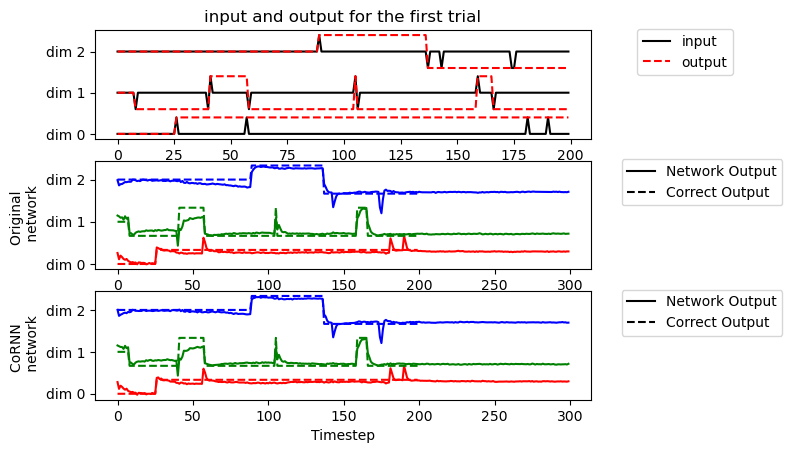

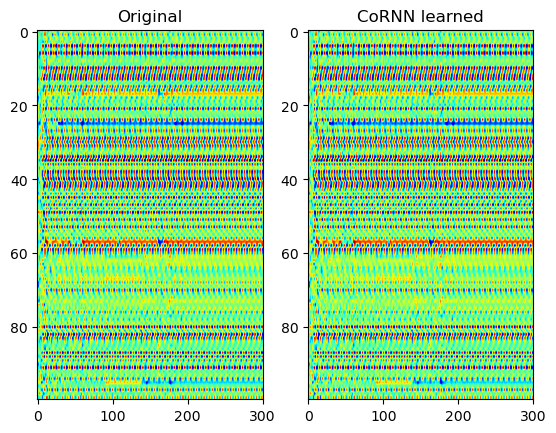

(-0.5, 0.5)

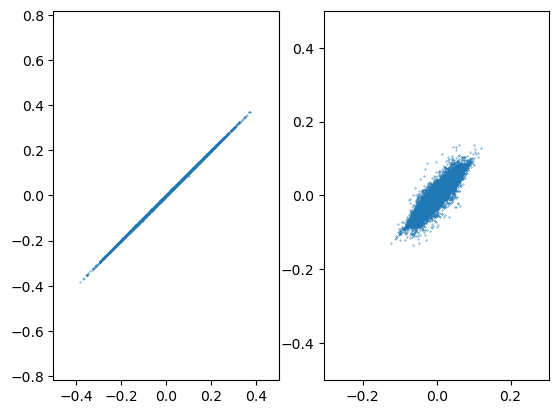

In [6]:
#% Plot the task structure
plt.subplot(311)
kbit_task.visualize_trial(inputs, outputs)
plt.subplot(312)
kbit_task.visualize_rnn_output(z_out, outputs)
plt.ylabel('Original \n network')
plt.subplot(313)
kbit_task.visualize_rnn_output(z_out_cornn, outputs)
plt.ylabel('CoRNN \n network')
plt.show()

#% Plot the neural activities 
plt.subplot(121)
plt.imshow(r[:,:100].T,aspect = 'auto',cmap = 'jet',interpolation = None)
plt.title('Original')
plt.subplot(122)
plt.imshow(r_cornn[:,:100].T,aspect = 'auto',cmap = 'jet',interpolation = None)
plt.title('CoRNN learned')
plt.show()

#%%
plt.subplot(121)
plt.scatter(w_in.flatten(),w_in_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)


plt.subplot(122)
plt.scatter(w_rec.flatten(),w_rec_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)



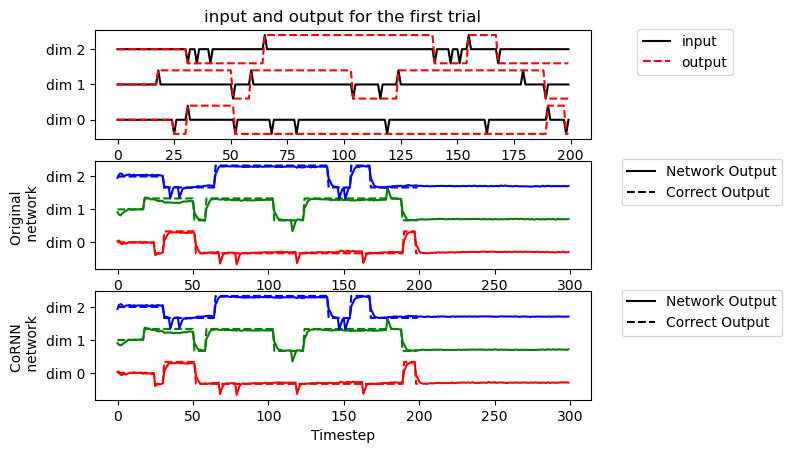

In [110]:
#% Plot the task structure
plt.subplot(311)
kbit_task.visualize_trial(inputs, outputs)
plt.subplot(312)
kbit_task.visualize_rnn_output(z_out, outputs)
plt.ylabel('Original \n network')
plt.subplot(313)
kbit_task.visualize_rnn_output(z_out_cornn, outputs)
plt.ylabel('CoRNN \n network')
plt.savefig("Figure5a.pdf", bbox_inches='tight')
plt.show()

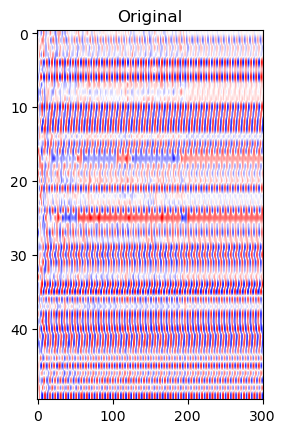

In [111]:
from matplotlib import cm
#% Plot the neural activities 
plt.subplot(121)
plt.imshow(r[:,:50].T,aspect = 'auto',cmap = cm.bwr, interpolation = None, vmin=-1,vmax=1)
plt.title('Original')
plt.savefig("Figure5b1.pdf", bbox_inches='tight')
plt.show()

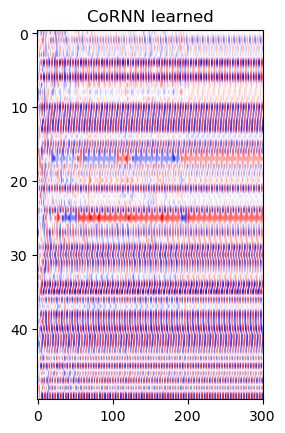

In [113]:
plt.subplot(122)
plt.imshow(r_cornn[:,:50].T,aspect = 'auto',cmap = cm.bwr, interpolation = None, vmin=-1,vmax=1)
plt.title('CoRNN learned')
plt.savefig("Figure5b2.pdf", bbox_inches='tight')
plt.show()
plt.show()

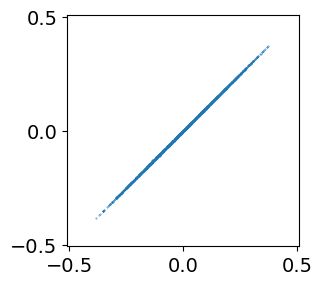

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plt.scatter(w_in.flatten(),w_in_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.51,0.51)
plt.ylim(-0.51,0.51)
plt.xticks(np.linspace(-0.5,0.5,3),fontsize=14)
plt.yticks(np.linspace(-0.5,0.5,3),fontsize=14)
plt.savefig("Figure5c1.png", bbox_inches='tight', dpi=300)
plt.show()


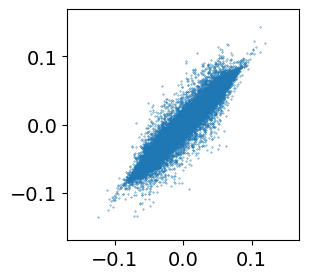

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plt.scatter(w_rec.flatten(),w_rec_cornn.flatten(),.1)
plt.axis('equal')
plt.xlim(-0.17,0.17)
plt.ylim(-0.17,0.17)
plt.xticks(np.linspace(-0.1,0.1,3),fontsize=14)
plt.yticks(np.linspace(-0.1,0.1,3),fontsize=14)
plt.savefig("Figure5c2.png", bbox_inches='tight', dpi=300)
plt.show()